### Importamos variables

In [1]:
### Manipulación de Datos
import pandas as pd
import numpy as np

### Visualización de Datos
import seaborn as sns
import matplotlib.pyplot as plt

### Tratamiento de datos
from utils.funciones import CategoricalAnalysis, extended_describe

### Importamos datos    

In [2]:
df = pd.read_csv(r"data\raw\Status_Analysis.csv")
df.head()

,customer_id,satisfaction_score,cltv,customer_status,churn_score,churn_label,churn_value,churn_category,churn_reason
0,0002-ORFBO,3,2205,Stayed,65,No,0,Not Applicable,NaN
1,0003-MKNFE,5,5414,Stayed,66,No,0,Not Applicable,NaN
2,0004-TLHLJ,1,4479,Churned,71,Yes,1,Competitor,Competitor had better devices
3,0011-IGKFF,1,3714,Churned,91,Yes,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,1,3464,Churned,68,Yes,1,Dissatisfaction,Network reliability


|Column Name |	Description| 
|--------------|----------|
|CustomerID|	A unique ID that identifies each customer.|
|cltv | Customer Lifetime Value|
|Satisfaction Score|	A customer's overall satisfaction rating from 1 (Very Unsatisfied) to 5 (Very Satisfied).|
|Customer Status|	Status of the customer at quarter end: Churned, Stayed, or Joined|
|Churn Label|	Yes = left company this quarter; No = remained with company|
|Churn Value|	1 = left company this quarter; 0 = remained with company|
|Churn Score|	Value from 0-100 indicating likelihood to churn based on predictive IBM SPSS modeler.|

In [3]:
print(f'La base de datos a analizar posee {df.shape[0]} filas y {df.shape[1]} columnas')
print(f'\nLas features que tenemos son: {list(df.columns)}')

La base de datos a analizar posee 7043 filas y 9 columnas

Las features que tenemos son: ['customer_id', 'satisfaction_score', 'cltv', 'customer_status', 'churn_score', 'churn_label', 'churn_value', 'churn_category', 'churn_reason']


### Primera exploración

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         7043 non-null   object
 1   satisfaction_score  7043 non-null   int64 
 2   cltv                7043 non-null   int64 
 3   customer_status     7043 non-null   object
 4   churn_score         7043 non-null   int64 
 5   churn_label         7043 non-null   object
 6   churn_value         7043 non-null   int64 
 7   churn_category      7043 non-null   object
 8   churn_reason        1869 non-null   object
dtypes: int64(4), object(5)
memory usage: 495.3+ KB


In [5]:
df.describe()

,satisfaction_score,cltv,churn_score,churn_value
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,3.244924,4400.295755,58.505040,0.265370
std,1.201657,1183.057152,21.170031,0.441561
min,1.000000,2003.000000,5.000000,0.000000
25%,3.000000,3469.000000,40.000000,0.000000
50%,3.000000,4527.000000,61.000000,0.000000
75%,4.000000,5380.500000,75.500000,1.000000
max,5.000000,6500.000000,96.000000,1.000000


In [6]:
df.describe(include="object")

,customer_id,customer_status,churn_label,churn_category,churn_reason
count,7043,7043,7043,7043,1869
unique,7043,3,2,6,20
top,9995-HOTOH,Stayed,No,Not Applicable,Competitor had better devices
freq,1,4720,5174,5174,313


In [7]:
df.isna().sum()

customer_id              0
satisfaction_score       0
cltv                     0
customer_status          0
churn_score              0
churn_label              0
churn_value              0
churn_category           0
churn_reason          5174
dtype: int64

In [8]:
df[df.duplicated()]

,customer_id,satisfaction_score,cltv,customer_status,churn_score,churn_label,churn_value,churn_category,churn_reason


- Hay que imputar los valores nulos de nuestra columna 'churn_reason', unas de las razones es porque cuando presentemos el mismo, tendremos una justificación de porque nuestros clientes podrían irse sin perder u/o olvidar que estos no lo dieron desde el inicio. 

Tenemos dos opciones, imputo todos los Nan como 'sin razón de abandono' o en base al 'churn_score' aplico la razón que más se repitió dentro de la misma. Por ejemplo el 'churn_score' para la razón 'Encontró nuevos servicios' se encuentra dentro del rango 30-40 entonces, todos los 'churn_score' de tipo Nan entre el rango 30-40 pasarán a poseer dicha razón de abandono.

In [9]:
# Crear grupos de 20 en churn_score (rango 0-20, 20-40, etc.)
df['churn_group'] = pd.cut(df['churn_score'], bins=range(0, 101, 10), right=False)

# Agrupar por churn_group y contar las razones
grouped = df.dropna(subset=['churn_reason']).groupby('churn_group', observed=False)['churn_reason'].value_counts()

# Extraer la razón más frecuente por grupo
most_common_reason = grouped.groupby('churn_group', observed=False).idxmax().apply(lambda x: x[1])

# Crear un diccionario para mapear rangos a razones
group_to_reason = most_common_reason.to_dict()

# Función para imputar los NaN
def imputar_razon(row):
    if pd.isna(row['churn_reason']) and pd.notna(row['churn_group']):
        return group_to_reason.get(row['churn_group'], 'Sin razón de abandono')
    return row['churn_reason']

# Imputar valores
df['razon_abandono'] = df.apply(imputar_razon, axis=1)

In [10]:
most_common_reason

churn_group
[0, 10)       Attitude of service provider
[10, 20)      Attitude of service provider
[20, 30)      Attitude of service provider
[30, 40)      Attitude of service provider
[40, 50)      Attitude of service provider
[50, 60)      Attitude of service provider
[60, 70)     Competitor had better devices
[70, 80)      Competitor made better offer
[80, 90)     Competitor had better devices
[90, 100)     Competitor made better offer
Name: count, dtype: object

In [11]:
df.isna().sum()

customer_id              0
satisfaction_score       0
cltv                     0
customer_status          0
churn_score              0
churn_label              0
churn_value              0
churn_category           0
churn_reason          5174
churn_group              0
razon_abandono           0
dtype: int64

In [12]:
df[df['churn_reason'].isna()]

,customer_id,satisfaction_score,cltv,customer_status,churn_score,churn_label,churn_value,churn_category,churn_reason,churn_group,razon_abandono
0,0002-ORFBO,3,2205,Stayed,65,No,0,Not Applicable,NaN,"[60, 70)",Competitor had better devices
1,0003-MKNFE,5,5414,Stayed,66,No,0,Not Applicable,NaN,"[60, 70)",Competitor had better devices
5,0013-MHZWF,3,5108,Stayed,55,No,0,Not Applicable,NaN,"[50, 60)",Attitude of service provider
6,0013-SMEOE,3,5011,Stayed,26,No,0,Not Applicable,NaN,"[20, 30)",Attitude of service provider
7,0014-BMAQU,4,4604,Stayed,49,No,0,Not Applicable,NaN,"[40, 50)",Attitude of service provider
...,...,...,...,...,...,...,...,...,...,...,...
7035,9979-RGMZT,3,5545,Stayed,38,No,0,Not Applicable,NaN,"[30, 40)",Attitude of service provider
7038,9987-LUTYD,4,3161,Stayed,59,No,0,Not Applicable,NaN,"[50, 60)",Attitude of service provider
7040,9992-UJOEL,5,5870,Joined,33,No,0,Not Applicable,NaN,"[30, 40)",Attitude of service provider
7041,9993-LHIEB,3,4792,Stayed,59,No,0,Not Applicable,NaN,"[50, 60)",Attitude of service provider


In [13]:
(df['churn_label'].map({'No': 0, 'Yes': 1}) == df['churn_value']).all() ## Realizamos un mapeo para modificar el churn_label de tipo string a númerico y comparar ambos y la respuesta
## que nos devuelve es de np.true por ende son totalmente lo mismo

np.True_

- 'Churn_value' y 'churn_label' significan lo mismo, solo que uno se presenta de forma númerica y otro en letras. En este caso como solo realizaremos un análisis no requerimos de la parte númerica para un modelo de machine learning, por ende prescindiré de dicha columna por el momento.


In [14]:
df.drop(columns=['churn_reason', 'churn_score', 'churn_value'], inplace=True)

In [15]:
df.head()

,customer_id,satisfaction_score,cltv,customer_status,churn_label,churn_category,churn_group,razon_abandono
0,0002-ORFBO,3,2205,Stayed,No,Not Applicable,"[60, 70)",Competitor had better devices
1,0003-MKNFE,5,5414,Stayed,No,Not Applicable,"[60, 70)",Competitor had better devices
2,0004-TLHLJ,1,4479,Churned,Yes,Competitor,"[70, 80)",Competitor had better devices
3,0011-IGKFF,1,3714,Churned,Yes,Dissatisfaction,"[90, 100)",Product dissatisfaction
4,0013-EXCHZ,1,3464,Churned,Yes,Dissatisfaction,"[60, 70)",Network reliability


- Poseemos un dataset con valores nulos -> 'churn_reason'.
- La mayoría de nuestras predicciones 'churn_score' superan el 50%.
- Al tener un customer_id unico para cada, no poseemos duplicados

In [16]:
df.to_csv(path_or_buf=r'data\clean\status_analysis_clean.csv',index=False)

### Análisis exploratorio

#### Análisis univariante

In [17]:
df = pd.read_csv(r"data\clean\status_analysis_clean.csv")
df.head()

,customer_id,satisfaction_score,cltv,customer_status,churn_label,churn_category,churn_group,razon_abandono
0,0002-ORFBO,3,2205,Stayed,No,Not Applicable,"[60, 70)",Competitor had better devices
1,0003-MKNFE,5,5414,Stayed,No,Not Applicable,"[60, 70)",Competitor had better devices
2,0004-TLHLJ,1,4479,Churned,Yes,Competitor,"[70, 80)",Competitor had better devices
3,0011-IGKFF,1,3714,Churned,Yes,Dissatisfaction,"[90, 100)",Product dissatisfaction
4,0013-EXCHZ,1,3464,Churned,Yes,Dissatisfaction,"[60, 70)",Network reliability


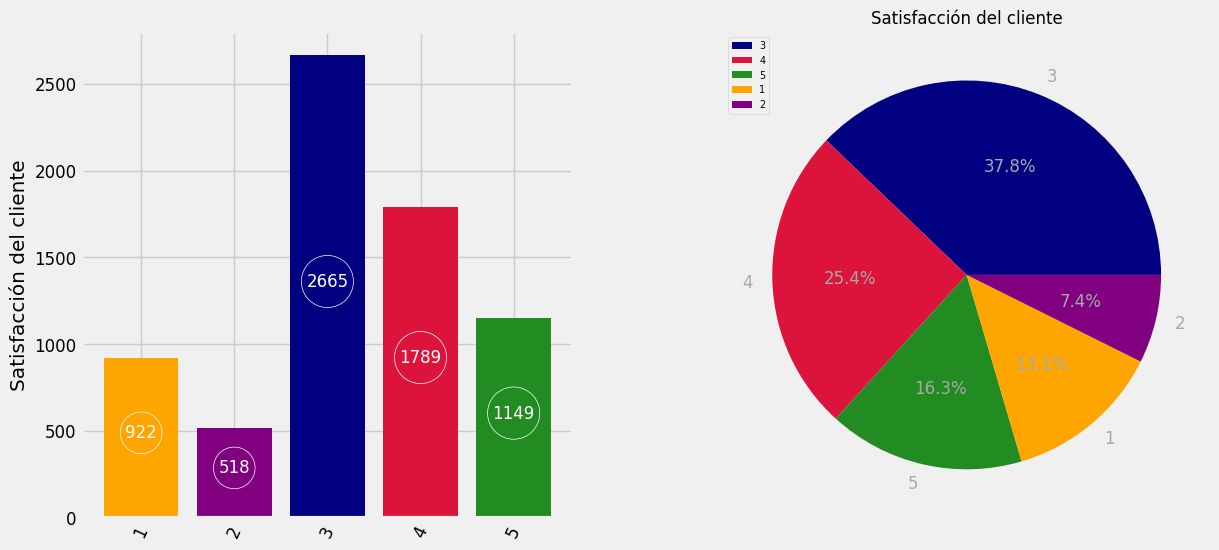

In [18]:
categorical_analyzer = CategoricalAnalysis(df=df)
categorical_analyzer.plot_top_categories(title='Satisfacción del cliente', labely='Satisfacción del cliente', column_name='satisfaction_score')

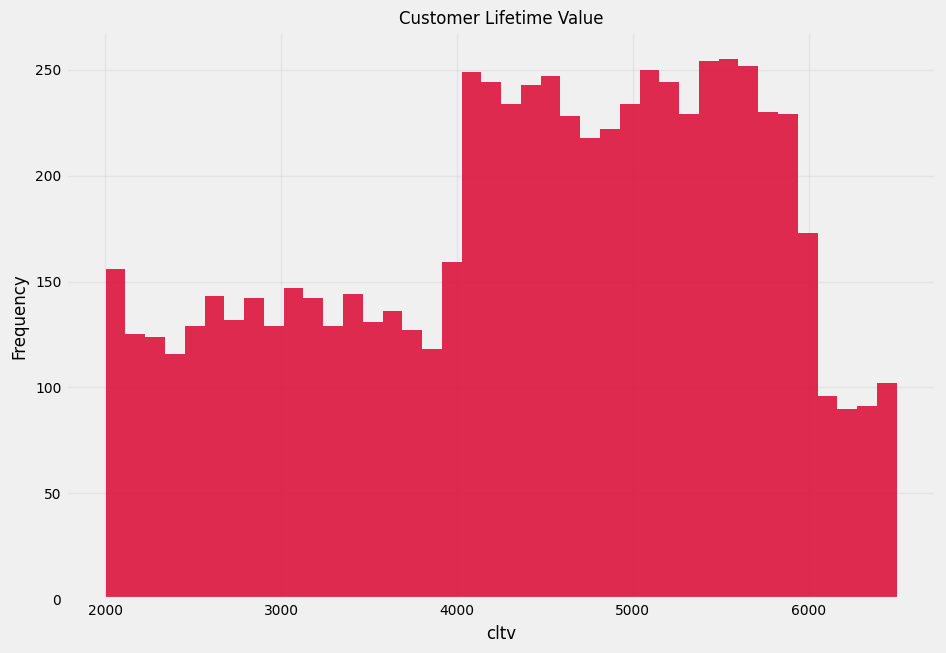

La distribución es platicúrtica con una curtosis de -0.93. Los datos se encuentran dispersos.
La distribución se encuentra sesgada hacia la derecha -0.31.


,count,mean,median,mode,std,min,25%,50%,75%,max,kurtosis,skewness
cltv,7043.0,4400.295755,4527.0,5546,1183.06,2003.0,3469.0,4527.0,5380.5,6500.0,-0.93,-0.31


In [19]:
categorical_analyzer.plot_distribution(title= 'Customer Lifetime Value', column_name='cltv', cant_bins = 40, color='crimson', rotation=0, alpha=0.9)

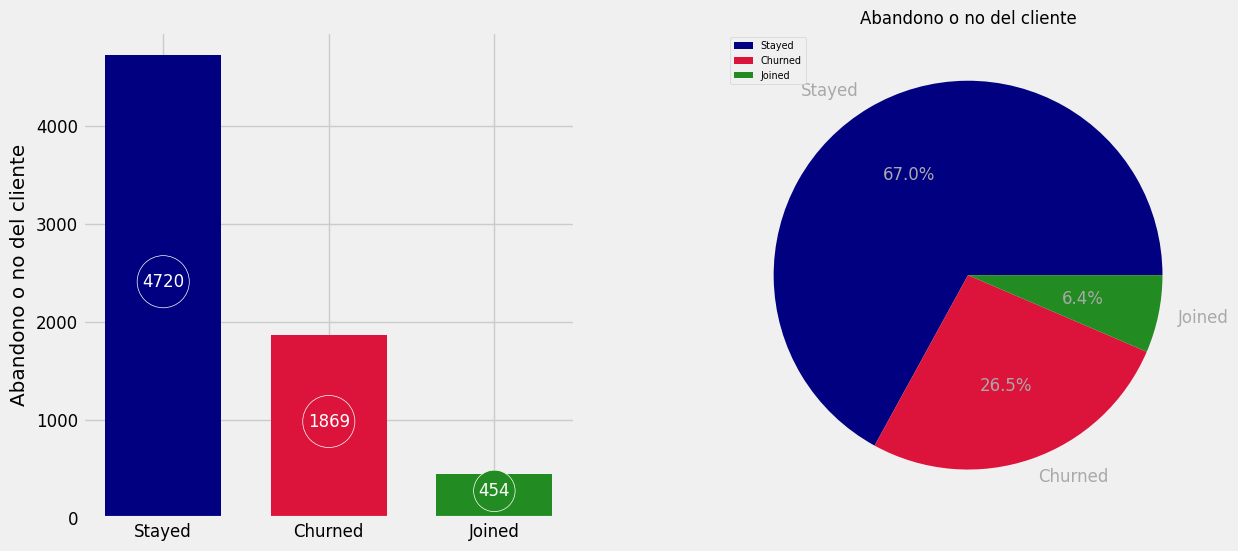

In [20]:
categorical_analyzer.plot_top_categories(title='Abandono o no del cliente', labely='Abandono o no del cliente', column_name='customer_status')

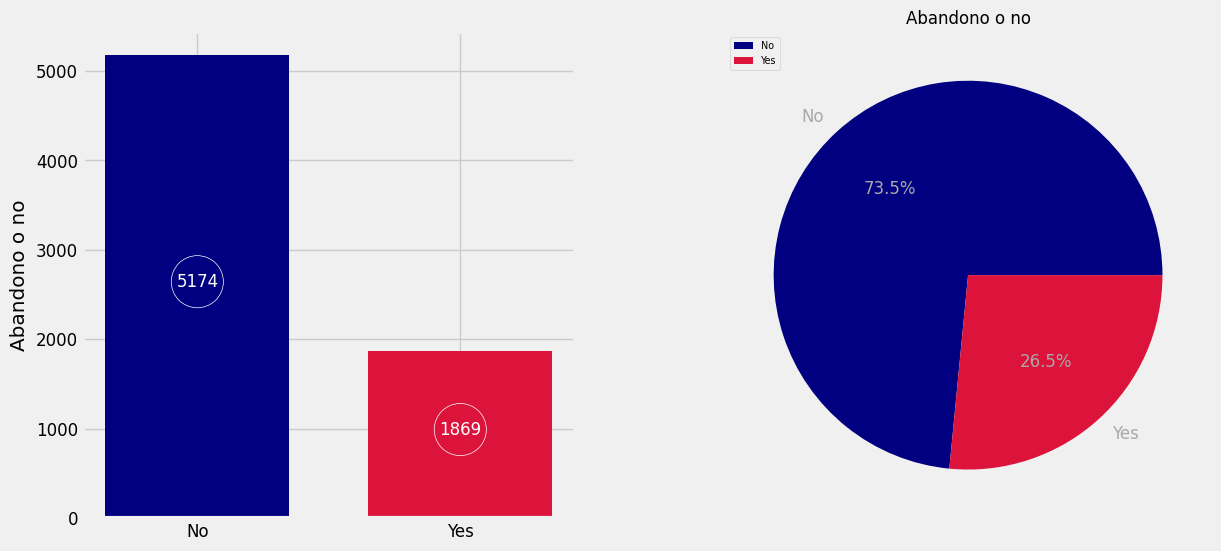

In [21]:
categorical_analyzer.plot_top_categories(title='Abandono o no', labely='Abandono o no', column_name='churn_label')

In [22]:
df.columns

Index(['customer_id', 'satisfaction_score', 'cltv', 'customer_status',
       'churn_label', 'churn_category', 'churn_group', 'razon_abandono'],
      dtype='object')

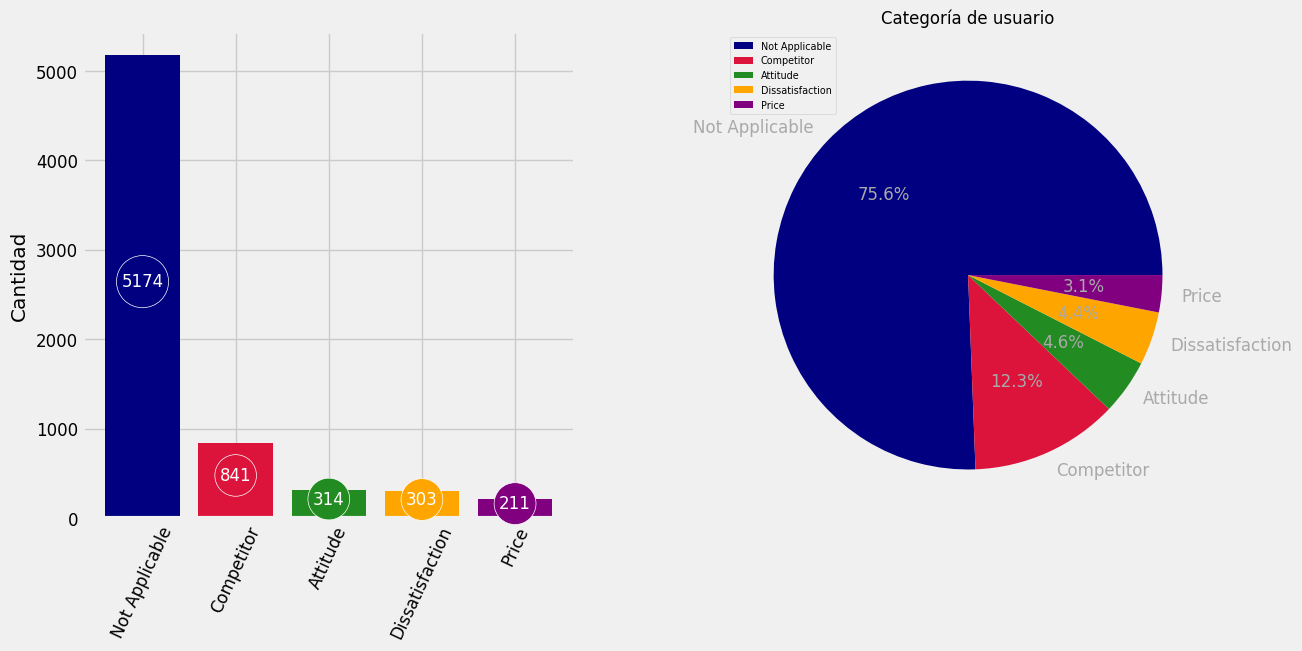

In [23]:
categorical_analyzer.plot_top_categories(title='Categoría de usuario', labely='Cantidad', column_name='churn_category')

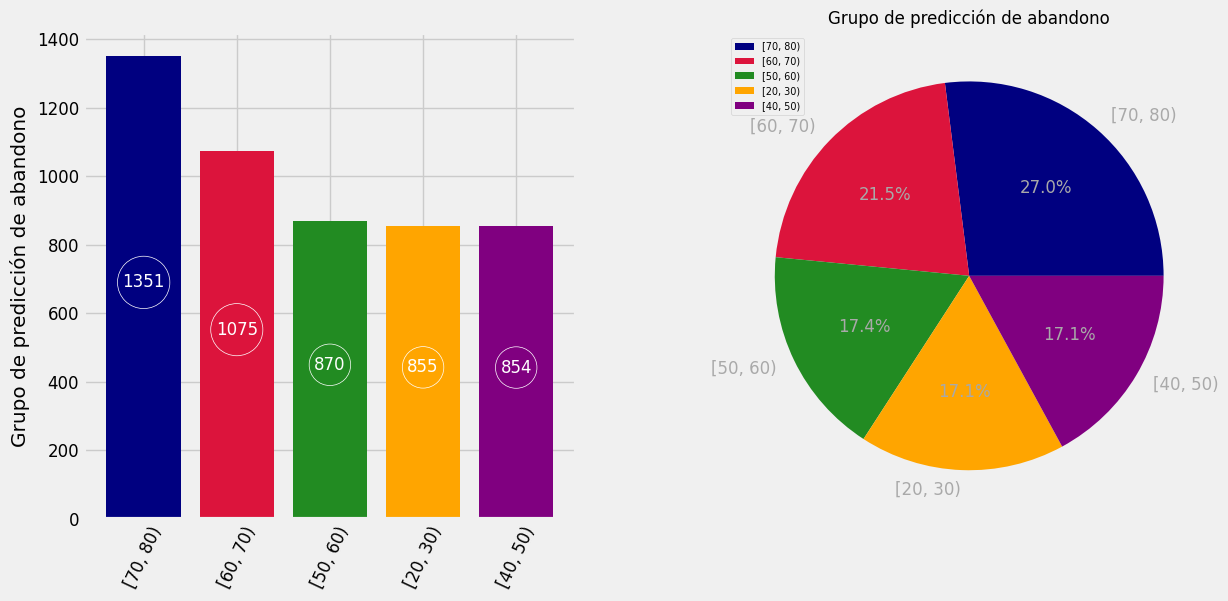

In [24]:
categorical_analyzer.plot_top_categories(title='Grupo de predicción de abandono', labely='Grupo de predicción de abandono', column_name='churn_group')

- Recordemos que hemos generado esta nueva columna con el fin de imputar valores nulos en la razón de abandono de nuestros usuarios. Esta basado con el fin de imputar la razón en base a la predicción ('churn_score') del modelo.

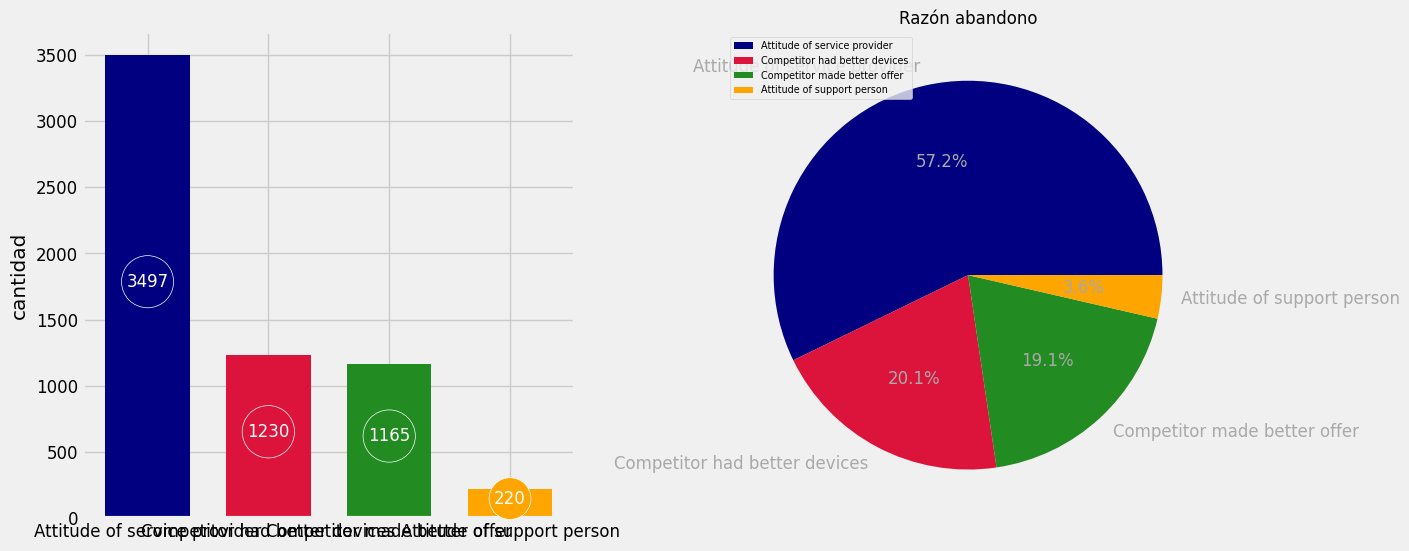

In [25]:
categorical_analyzer.plot_top_categories(title='Razón abandono', labely='cantidad', column_name='razon_abandono', n=4)